In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

import lmfit

### constants
twopi = 2 * np.pi

# Basic fitting with lmfit models

A very convenient toolset is provided by the lmfit package, in particular when using the model wrappers: https://lmfit.github.io/lmfit-py/model.html

This is a simple example on how to use it, using a simple sine model. All in all it is very simple to use:
* define the fit function. here: a sine with variable frequency, amplitude, phase, and an offset.
* use lmfit to construct a fit model automatically
* make an initial guess
* perform the fit

That is all that's needed in this case. See the lmfit documentation for more details.

C:\Users\wopfa\anaconda3\envs\analysis\lib\site-packages\lmfit\minimizer.py:772: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
C:\Users\wopfa\anaconda3\envs\analysis\lib\site-packages\lmfit\minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


<IPython.core.display.Javascript object>


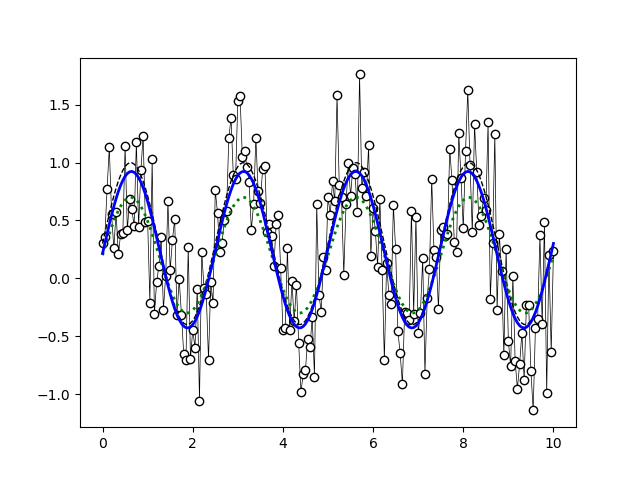

[[Model]]
    Model(sine)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 325
    # data points      = 201
    # variables        = 4
    chi-square         = 33.5364310
    reduced chi-square = 0.17023569
    Akaike info crit   = -351.925186
    Bayesian info crit = -338.711966
##  Warning: uncertainties could not be estimated:
[[Variables]]
    f:      0.40202371 +/-        nan (nan%) (init = 0.4)
    phi:   -0.04720571 +/- 0.00208890 (4.43%) (init = 0)
    of:     0.24757123 +/- 0.02910515 (11.76%) (init = 0.2)
    scale:  0.67651624 +/- 0.04133532 (6.11%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, scale) =  1.025
    C(phi, of)    = -0.430



In [2]:
f = 0.4 # the frequency
phi = 0 * np.pi/2. # the phase
of = 0.3 # offset
scale = 0.7 # scaling factor
noiselevel = 0.4 # scale of added noise (normally distributed)

# define the model
def sine(xs, f, phi, of, scale):
    return scale * np.sin(twopi * f * xs + phi) + of

sinemodel = lmfit.Model(sine)

# make some mock-data
xs = np.linspace(0, 10, 201)
y_ideal = sine(xs, f, phi, of, scale)
y_data = y_ideal + np.random.normal(loc=0, scale=noiselevel, size=xs.size)

# fitting.
# first make the params, and place some initial guess
p0 = sinemodel.make_params(f=0.4, phi=0, of=0.2, scale=0.5)

# perform the fit.
y_guess = sinemodel.eval(p0, xs=xs)
fit_result = sinemodel.fit(y_data, p0, xs=xs, method='nelder')
y_fit = sinemodel.eval(fit_result.params, xs=xs)

# plot: we're plotting the data, the ideal data, the initial guess, and the fit result.
fig, ax = plt.subplots(1, 1)
ax.plot(xs, y_data, 'ko-', mfc='w', mec='k', lw=0.5)
ax.plot(xs, y_ideal, 'k--', lw=1)
ax.plot(xs, y_guess, 'g:', lw=2)
ax.plot(xs, y_fit, 'b', lw=2)

print(fit_result.fit_report())

# Custom lmfit models

We can save us some manual labor if we're able to automatically determine a good initial guess from the data. That is particularly handy if we want to fit multiple data sets automatically. 

For our sine example, we can get a guess for frequency and phase from the FFT of the data, and amplitude and offset directly from the data. We can then write a simple extension of the model to include a guess function (see lmfit docs). This works pretty well -- no more manual guessing needed in this case.

C:\Users\wopfa\anaconda3\envs\analysis\lib\site-packages\lmfit\minimizer.py:772: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
C:\Users\wopfa\anaconda3\envs\analysis\lib\site-packages\lmfit\minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


<IPython.core.display.Javascript object>


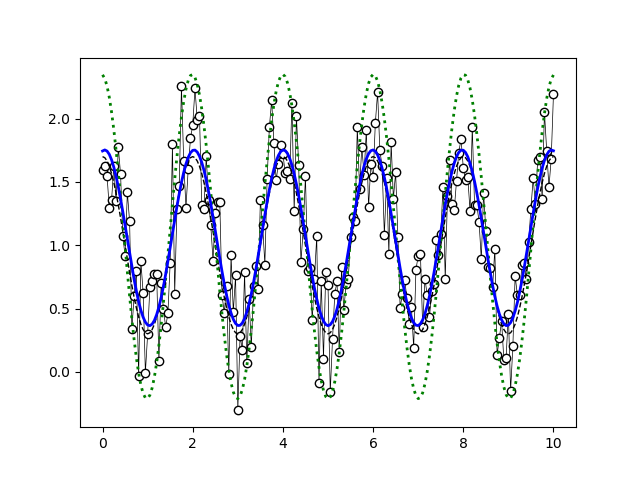

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 186
    # data points      = 201
    # variables        = 4
    chi-square         = 17.5727617
    reduced chi-square = 0.08920184
    Akaike info crit   = -481.827922
    Bayesian info crit = -468.614702
##  Warning: uncertainties could not be estimated:
[[Variables]]
    f:      0.50470375 +/-        nan (nan%) (init = 0.4975124)
    phi:    1.41503073 +/- 0.00355896 (0.25%) (init = 1.641343)
    of:     1.05859329 +/- 0.02099379 (1.98%) (init = 1.068481)
    scale:  0.69427906 +/- 0.02958425 (4.26%) (init = 1.281093)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, of)    = -1.029
    C(phi, scale) = -0.317



In [3]:
### Define the model class
class SineModel(lmfit.Model):
    
    @staticmethod
    def func(xs, f, phi, of, scale):
        return scale * np.sin(twopi * f * xs + phi) + of
    
    def __init__(self):
        super().__init__(SineModel.func)
        
    def guess(self, data, xs):
        """Simple initial guess from the FFT of the data."""
        dx = (xs[1:]-xs[:-1]).mean()
        ffty = np.fft.rfft(data)
        ffty[0] = 0. # remove the DC component
        fftx = np.fft.rfftfreq(data.size, d=dx)
        fidx = np.argmax(np.abs(ffty))
        
        # make the parameters. notes:
        # * since we're fitting with since, we have to rotate the fft result to get the right frame.
        # * the noisier this 
        p0 = self.make_params(f=fftx[fidx], phi=np.angle(ffty[fidx] * np.exp(1j*np.pi/2.)), 
                              of=data.mean(), scale=(data.max()-data.min())/2.)
        return p0
    
sinemodel = SineModel()


### Example parameters
f = 0.5 # the frequency
phi = np.pi/2. # the phase
of = 1 # offset
scale = 0.7 # scaling factor
noiselevel = 0.3 # scale of added noise (normally distributed)


### make some mock-data
xs = np.linspace(0, 10, 201)
p_ideal = sinemodel.make_params(f=f, phi=phi, of=of, scale=scale)
y_ideal = sinemodel.eval(p_ideal, xs=xs)
y_data = y_ideal + np.random.normal(loc=0, scale=noiselevel, size=xs.size)

### fitting

# first, initial guess. in principle we can still work on p0 if we needed to.
p0 = sinemodel.guess(y_data, xs)
y_guess = sinemodel.eval(p0, xs=xs)

# perform the fit
fit_result = sinemodel.fit(y_data, p0, xs=xs, method='nelder')
y_fit = sinemodel.eval(fit_result.params, xs=xs)

fig, ax = plt.subplots(1, 1)
ax.plot(xs, y_data, 'ko-', mfc='w', mec='k', lw=0.5)
ax.plot(xs, y_ideal, 'k--', lw=1)
ax.plot(xs, y_guess, 'g:', lw=2)
ax.plot(xs, y_fit, 'b', lw=2)

print(fit_result.fit_report())

# Fitting asymmetric resonator responses

This is a more interesting, real-world example based on complex data. The lmfit model supports complex data out-of-the-box, which is very handy. Below you can find a very simple implementation for fitting asymmetric ('hanger'-type) resonator responses. For the physical model, see Khalil et al., J. Appl. Phys. (2011) (https://arxiv.org/abs/1108.3117). 

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 2002
    # variables        = 6
    chi-square         = 5.05029338
    reduced chi-square = 0.00253021
    Akaike info crit   = -11964.8762
    Bayesian info crit = -11931.2647
[[Variables]]
    f0:             5.0000e+08 +/- 3695.22481 (0.00%) (init = 4.996e+08)
    Q_i:           -9.8700e+10 +/- 1.0133e+16 (10266080.37%) (init = 1000000)
    Q_e_mag:        401.489331 +/- 2.62395935 (0.65%) (init = 500)
    Q_e_phase:     -0.78297140 +/- 0.00584180 (0.75%) (init = 0)
    amp_slope:      0.21772765 +/- 0.14827172 (68.10%) (init = 0)
    amp_offset:     0.99730644 +/- 0.00171033 (0.17%) (init = 1)
    phase_winding:  0 (fixed)
    phase_offset:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(f0, Q_e_phase)         = -0.688
    C(Q_i, Q_e_phase)        =  0.581
    C(f0, Q_i)               = -0.392
    C(Q_e_phase, amp_offset) =  0.

<IPython.core.display.Javascript object>


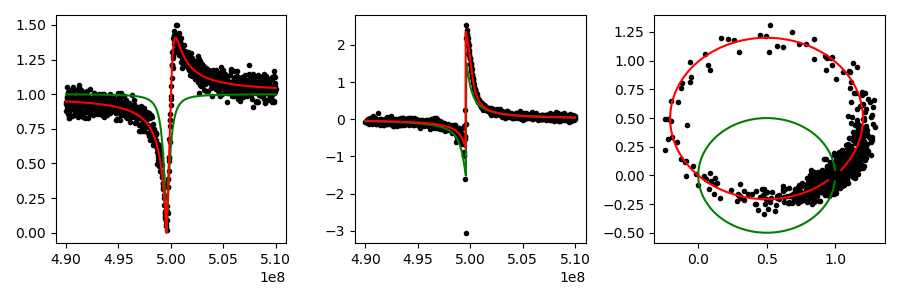

In [4]:
class AssymS21Model(lmfit.Model):
    
    @staticmethod
    def s21_khalil(fs, f0, Q_i, Q_e_mag, Q_e_phase):
        Q_e = Q_e_mag * np.exp(-1j * Q_e_phase)
        Q_c = 1./((1./Q_e).real)
        Q_tot = 1./(1./Q_i + 1./Q_c)
        return 1. - (Q_tot/Q_e_mag * np.exp(1j*Q_e_phase)) / (1 + 2j * Q_tot * (fs-f0)/f0)
    
    @staticmethod
    def func(fs, f0, Q_i, Q_e_mag, Q_e_phase, amp_slope, amp_offset, phase_winding, phase_offset):
        sig = AssymS21Model.s21_khalil(fs, f0, Q_i, Q_e_mag, Q_e_phase)
        sig *= amp_offset * (1. + amp_slope * (fs-f0)/f0)
        sig *= np.exp(1j * (phase_offset + phase_winding * fs))
        return sig
    
    def __init__(self):
        super().__init__(AssymS21Model.func)
        
s21model = AssymS21Model()


### Example parameters and mock data
p_ideal = s21model.make_params(
    f0 = 5e8,
    Q_i = 1e5,
    Q_e_mag = 400,
    Q_e_phase = -np.pi/4.,
    amp_slope = 0,
    amp_offset = 1.,
    phase_winding = 0,
    phase_offset = 0,
)

fs = np.linspace(4.9, 5.1, 1001) * 1e8
y_ideal = s21model.eval(p_ideal, fs=fs)

# for mock data, add real and imaginary noise
y_data = y_ideal + np.random.normal(scale=0.05, size=fs.size) + 1j*np.random.normal(scale=0.05, size=fs.size)


### fitting
p_guess = s21model.make_params(
    f0 = fs[np.argmin(np.abs(y_data))],
    Q_i = 1e6,
    Q_e_mag = 500,
    Q_e_phase = 0,
    amp_slope = 0,
    amp_offset = 1,
    phase_winding = 0,
    phase_offset = 0,
)

# let's assume we've measured some of our line properties beforehand, and can fix them
# to an independently established value
p_guess['phase_winding'].vary = False
p_guess['phase_offset'].vary = False


y_guess = s21model.eval(p_guess, fs=fs)
fit_result = s21model.fit(y_data, p_guess, fs=fs, method='leastsq')
y_fit = s21model.eval(fit_result.params, fs=fs)

print(fit_result.fit_report())


### plotting
fig, axes = plt.subplots(1, 3, figsize=(9,3))

# magnitude
ax = axes[0]
ax.plot(fs, np.abs(y_data), 'k.')
ax.plot(fs, np.abs(y_guess), 'g-')
ax.plot(fs, np.abs(y_fit), 'r-')

# phase
ax = axes[1]
ax.plot(fs, np.angle(y_data), 'k.')
ax.plot(fs, np.angle(y_guess), 'g-')
ax.plot(fs, np.angle(y_fit), 'r-')

# circle
ax = axes[2]
ax.plot(y_data.real, y_data.imag, 'k.')
ax.plot(y_guess.real, y_guess.imag, 'g-')
ax.plot(y_fit.real, y_fit.imag, 'r-')

fig.tight_layout()